## Read the starting comment in train_backup.py

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from dataset import ImageDataset
import config
from torch import optim
from unet_models import unet
from torch import nn
from utils.dice_score import dice_loss
import torch.nn.functional as F

import matplotlib.pyplot as plt


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()


In [3]:
# Creating Dataloader
train_set = ImageDataset(config.TRAIN_DIR)
train_dl = DataLoader(train_set, shuffle=True, batch_size=config.TRAIN_BATCH_SIZE)

val_set = ImageDataset(config.VAL_DIR)
val_dl = DataLoader(val_set, shuffle=False, batch_size=config.VAL_BATCH_SIZE)


In [6]:
model = unet.UNet(3, 3).to(config.DEVICE)
optimizer = optim.RMSprop(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-8, momentum=0.999, foreach=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
grad_scaler = torch.amp.GradScaler('cuda')
criterion = nn.CrossEntropyLoss()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [7]:
images, targets = next(iter(train_dl))

images = images.to(device=config.DEVICE, dtype=torch.float32, memory_format=torch.channels_last)
targets = targets.to(device=config.DEVICE, dtype=torch.long)

images.shape, targets.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 3, 512, 512]))

In [8]:
with torch.autocast(config.DEVICE if config.DEVICE != 'mps' else 'cpu', enabled=True):
    targets_pred = model(images)
    loss = criterion(targets_pred, targets.to(torch.float))
    loss += dice_loss(
        targets_pred.float(),
        targets.float(),
    )

In [ ]:
gradient_clipping: float = 1.0

optimizer.zero_grad(set_to_none=True)
grad_scaler.scale(loss).backward()
grad_scaler.unscale_(optimizer)
torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
grad_scaler.step(optimizer)
grad_scaler.update()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


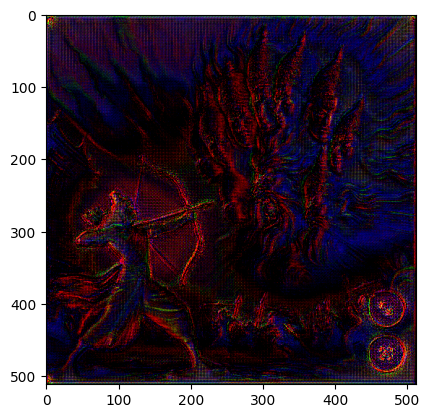

In [20]:
plt.imshow(targets_pred[0].permute(1,2,0).float().detach().numpy())